# DAS Power Spectral Density in Space

In [144]:
import gc
import os
import utm
import h5py
import glob
import datetime
import time as time
import pandas as pd
import scipy.signal as sgn
import geopy.distance as geo
import seisbench.models as sbm

from tqdm import tqdm
from obspy import read_events
from obspy.taup import TauPyModel
from distaz import DistAz
from joblib import Parallel, delayed
from collections import OrderedDict
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split

from das_util import try_gpu
from das_denoise_models import unet, dataflow, datalabel
from das_denoise_training import train_augmentation
from ELEP.elep.ensemble_coherence import ensemble_semblance 

import numpy as np
from numpy.random import default_rng

import torch
import torch.nn as nn
import torch.multiprocessing as mp
from torch.utils.data import DataLoader

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20


### Directories
raw_dir = '/fd1/QibinShi_data/akdas/qibin_data/'
out_dir = 'plots_test_picking_dec_ch1500/'

sample_rate = 25
dchan = 9.5714

ch_max = 7500  # max channel of each cable (4500 or 6000)

## OOI Northern cable 1 minute

In [93]:
raw_dir = '/fd1/QibinShi_data/OOI/North-C1-LR-P1kHx-GL1--m-Sp2m-test1_2021-11-01T09_16_11-0700/'
file1 = 'North-C1-LR-P1kHx-GL1--m-Sp2m-test1_2021-11-01T161619Z.h5'

with h5py.File(raw_dir+file1, 'r') as f:
#     time_data = f['Acquisition']['Raw[0]']['RawData'][:]
    timestamps = f['Acquisition']['Raw[0]']['RawDataTime'][:]
    sample_rate= f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    attrs_raw0 = dict(f['Acquisition']['Raw[0]'].attrs)
    
    pulse_rate = f['Acquisition'].attrs['PulseRate']
    gauge_len = f['Acquisition'].attrs['GaugeLength']
    dchannel = f['Acquisition'].attrs['SpatialSamplingInterval']
    attrs = dict(f['Acquisition'].attrs)
    
    attrs_cus = dict(f['Acquisition']['Custom'].attrs)

times=[datetime.datetime.utcfromtimestamp(time1/1e6) for time1 in timestamps]
attrs, attrs_raw0, attrs_cus

({'AcquisitionId': b'a13130d5-8544-4f21-ad1d-0d50272fd877',
  'GaugeLength': 51.04762,
  'GaugeLengthUnit': b'm',
  'MaximumFrequency': 500.0,
  'MinimumFrequency': 0.0,
  'NumberOfLoci': 32500,
  'PulseRate': 1000.0,
  'PulseWidth': 250.0,
  'PulseWidthUnit': b'ns',
  'SpatialSamplingInterval': 2.0419047,
  'SpatialSamplingIntervalUnit': b'm',
  'StartLocusIndex': 0,
  'TriggeredMeasurement': b'false',
  'VendorCode': b'OptaSense IU Setup 1.7.3 c5bde49175ee6dc70c95d4b39db648d3fda54a46',
  'schemaVersion': b'2.0',
  'uuid': b'a13130d5-8544-4f21-ad1d-0d50272fd877'},
 {'NumberOfLoci': 32500,
  'OutputDataRate': 1000.0,
  'RawDataUnit': b'rad * 2PI/2^16',
  'RawDescription': b'Diversity Processed Phase Dual Pulse Balanced. Ocp 20',
  'StartLocusIndex': 0,
  'uuid': b'3bf43b9d-ebc1-4dac-bc8d-7ca69fccec8e'},
 {'ADC Clock (MHz)': 1000,
  'Acquisition Start (CSU)': 0,
  'CSU Resolution (ns)': 1,
  'Carrier Separation (CSU)': 548,
  'CustomSchemaVersion': 3,
  'Data Compromised': 0,
  'Data Wi

### Visualize strain in several channels

/tmp/ipykernel_3003658/1959403434.py:13: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))


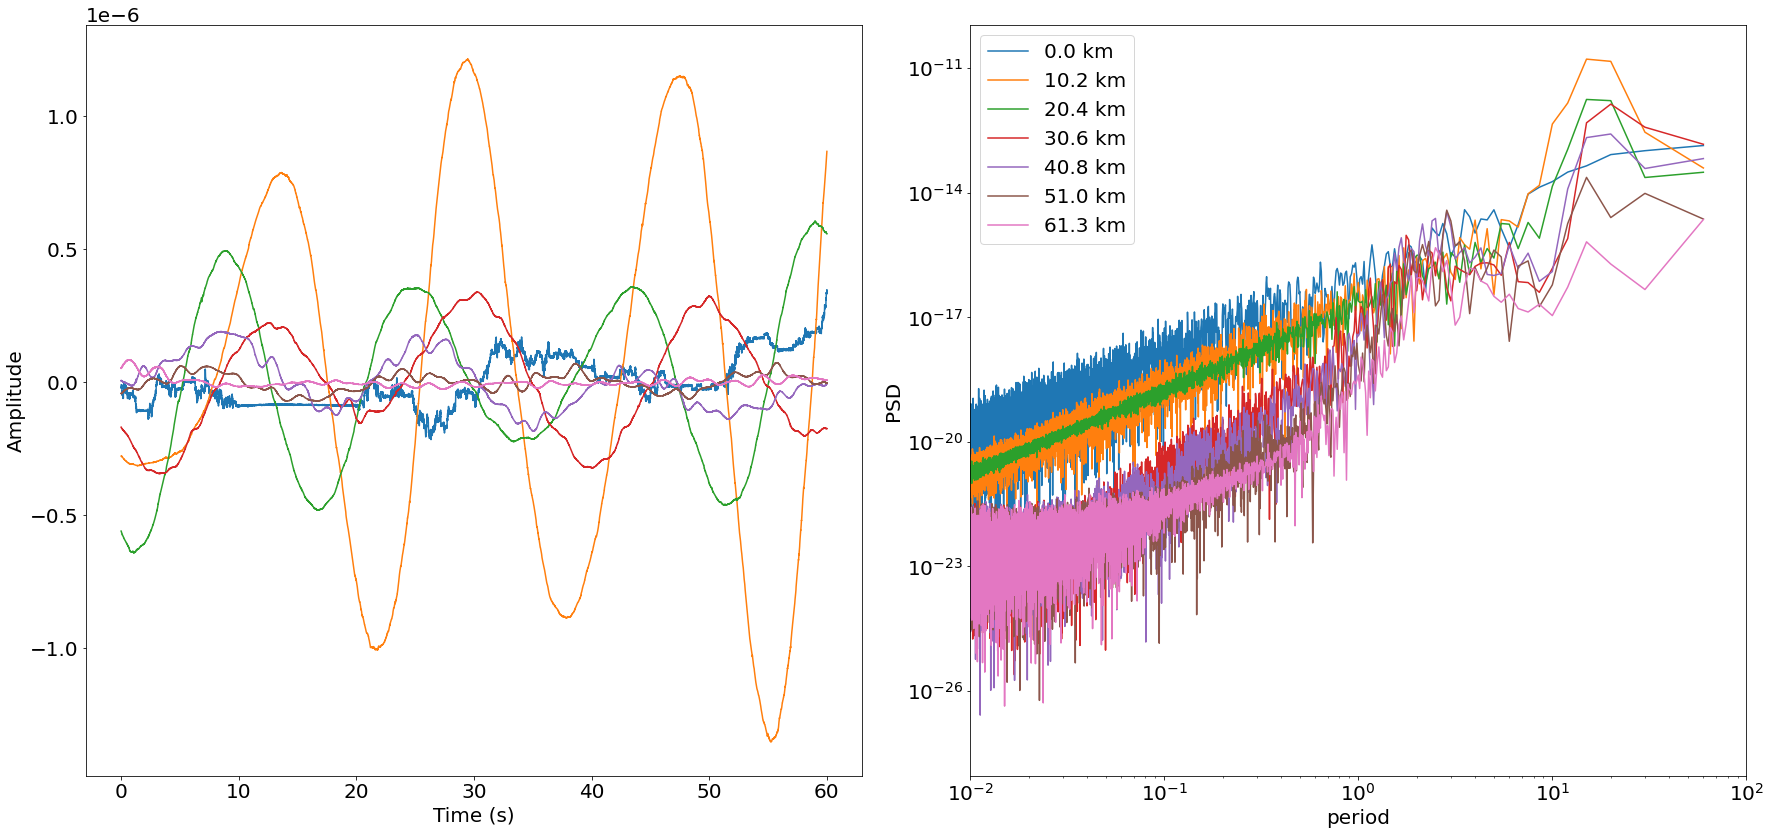

In [124]:
### Correct raw data to strain
time_amp = time_data.astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16

nx, ns = time_data.shape[0], time_data.shape[1]

### spectra for a few channels
fig,ax = plt.subplots(1,2,figsize=(25,12))
for chan in np.arange(0,nx,5000):
    tr = time_amp[chan,:]
    tr -= np.mean(tr) # remove the mean
    freq, psd = sgn.periodogram(tr, sample_rate, window='hamming')
    ax[0].plot(np.arange(ns) / sample_rate, tr)
    ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
    
ax[1].set_xlim([1e-2,1e2])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

## OOI Southern cable 20 minutes

In [150]:
raw_dir = '/fd1/QibinShi_data/OOI/south/'
files = glob.glob(raw_dir + 'South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T23??14Z.h5')
### Read 20 files and concatenate them
all_data = []
all_time = []
for i, file_name in tqdm(enumerate(files)):
    with h5py.File(file_name, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:]
        timestamps = f['Acquisition']['Raw[0]']['RawDataTime'][:]
        
        if i==0:
            sample_rate= f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
            gauge_len = f['Acquisition'].attrs['GaugeLength']
            dchannel = f['Acquisition'].attrs['SpatialSamplingInterval']
    all_data.append(time_data)
    all_time.append(timestamps)
    
full_data = np.concatenate(all_data, axis=1)
full_time = np.concatenate(all_time, axis=0)
times=[datetime.datetime.utcfromtimestamp(time1/1e6) for time1 in full_time]

### Visualize strain in several channels

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_3003658/257906541.py:13: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
100%|██████████| 10/10 [00:00<00:00, 62.88it/s]


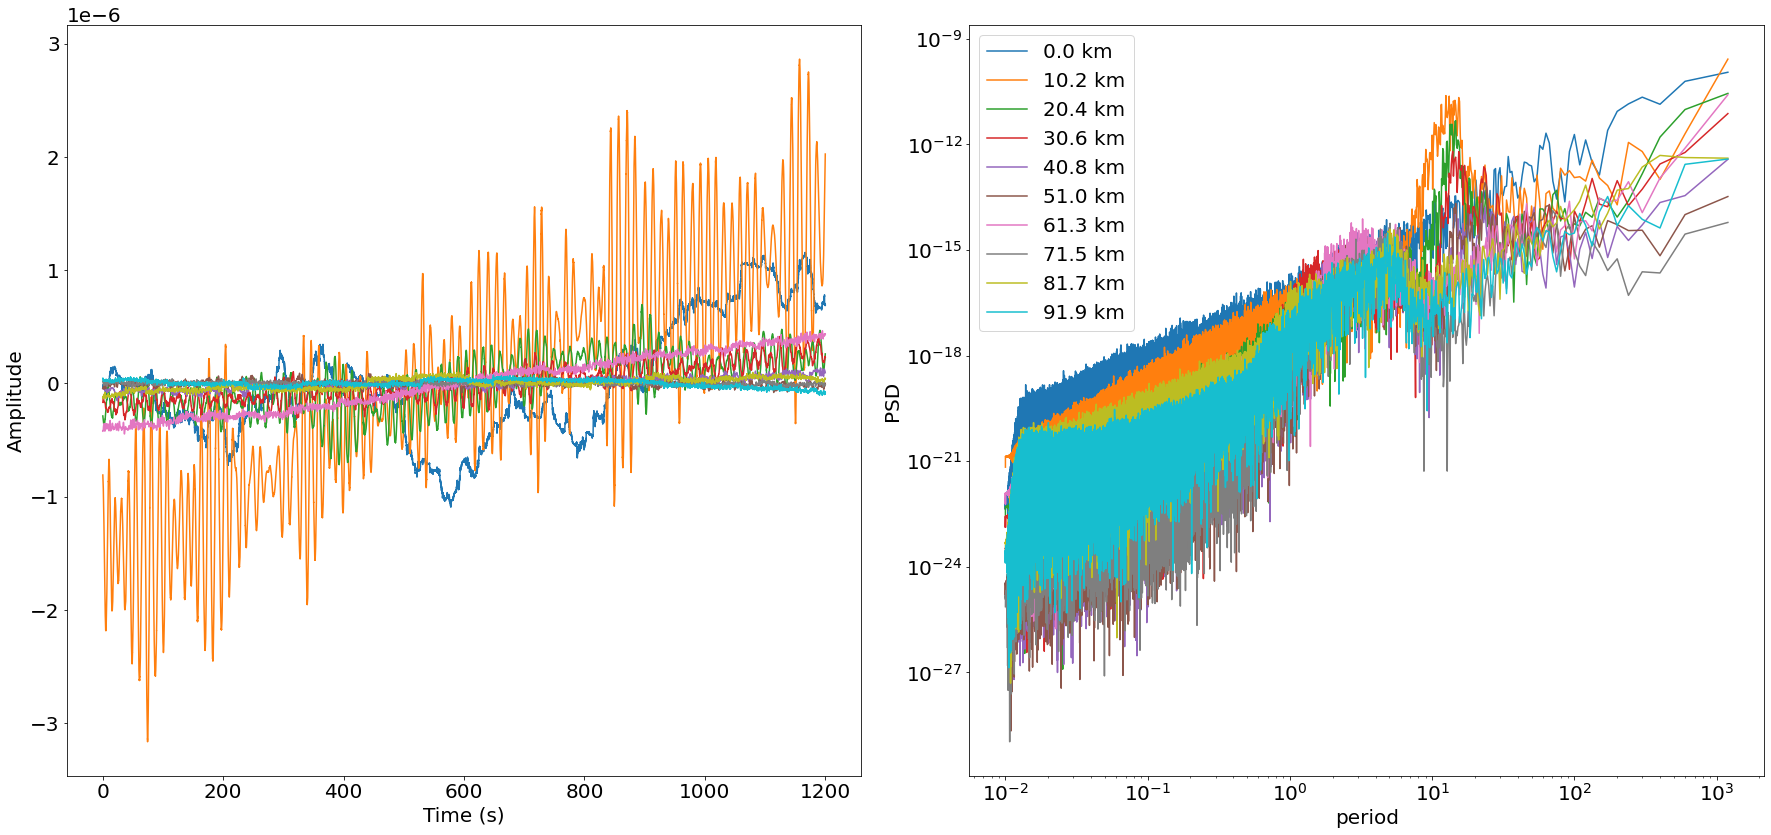

In [178]:
### No stacking
nx, ns = full_data.shape[0], full_data.shape[1]

fig,ax = plt.subplots(1,2,figsize=(25,12))

for chan in tqdm(np.arange(0,nx,5000)):
    ### Correct raw data to strain
    tr = full_data[chan,:].astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16
    tr -= np.mean(tr) # remove the mean
    freq, psd = sgn.periodogram(tr, sample_rate, window='hamming')
#     freq, psd = sgn.welch(tr, sample_rate)
    ax[0].plot(np.arange(ns) / sample_rate, tr)
    ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
    
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_3003658/3092687059.py:18: RuntimeWarning: divide by zero encountered in divide
  ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
100%|██████████| 5/5 [01:15<00:00, 15.15s/it]


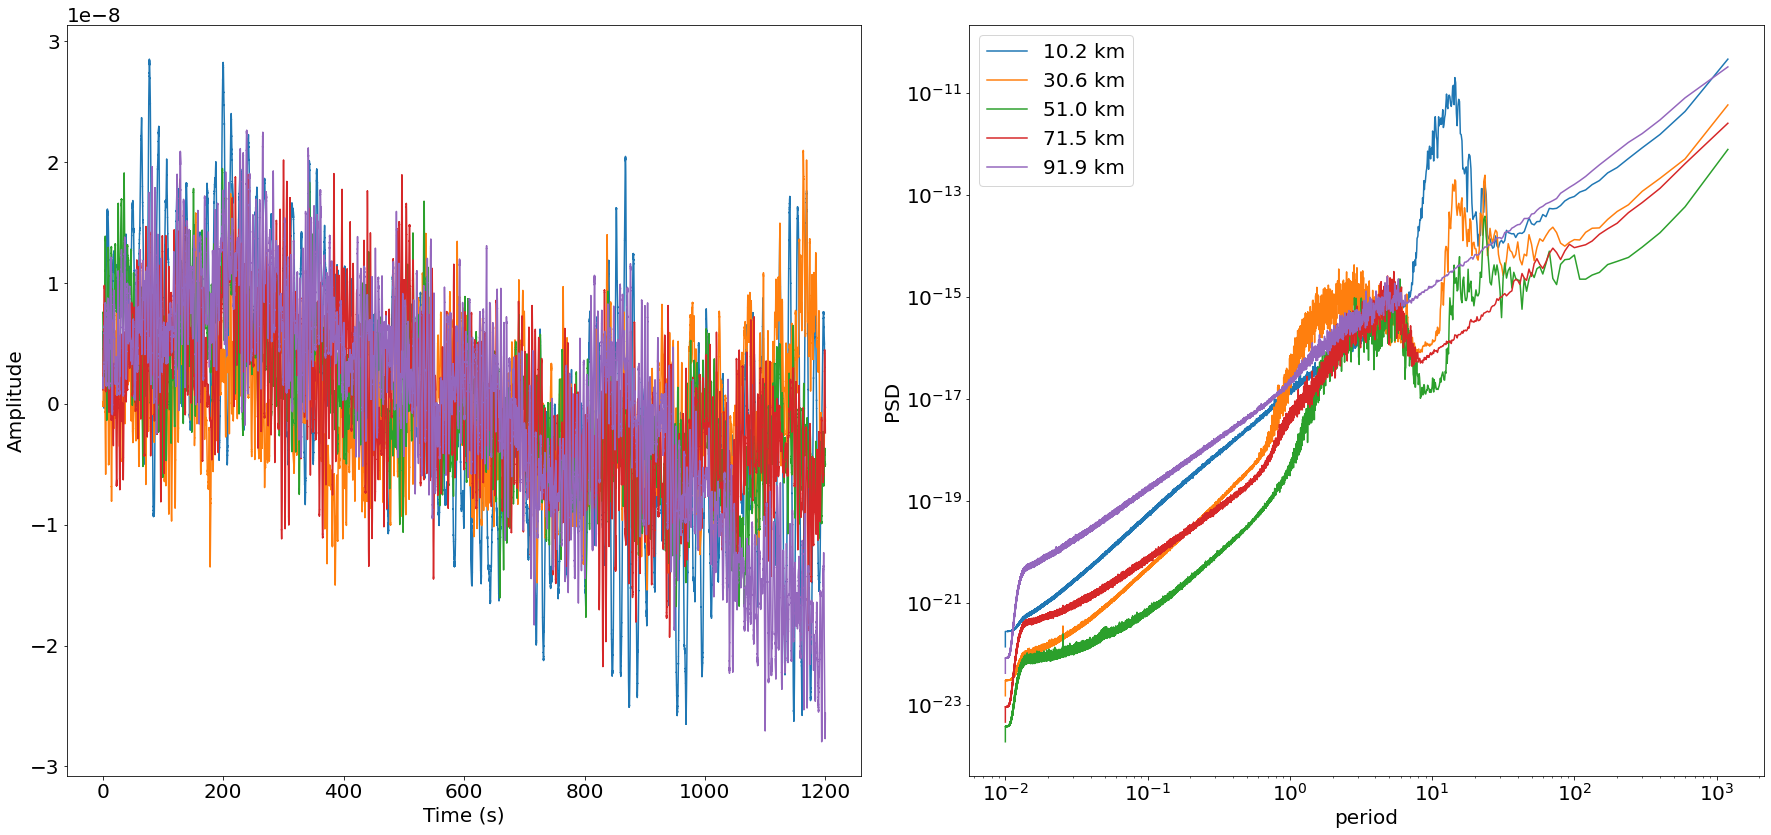

In [185]:
### stacking 1000 neighboring channels
fig,ax = plt.subplots(1,2,figsize=(25,12))

for chan in tqdm(np.arange(5000,nx,10000)):
    
    ### Correct raw data to strain
    trs = full_data[chan:chan+2000,:].astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16
    trs -= np.mean(trs, axis=1, keepdims=True) # remove the mean
    
    freq =[]
    psd = []
    for ch in range(2000):
        freq0, psd0 = sgn.periodogram(trs[ch,:], sample_rate, window='hamming')
        psd.append(psd0)
    
    psd_ave = np.mean(np.array(psd), axis=0)
    ax[0].plot(np.arange(ns) / sample_rate, np.mean(trs, axis=0))
    ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
    
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

## Alaska Cables

### Read DAS data

In [146]:
### Here we merge two DAS cables
### Make sure your data has complete samples in space and time
data_terra = raw_dir + 'TERRAtill2024_02_16.hdf5'
data_kkfls = raw_dir + 'KKFLStill2024_02_16.hdf5'
with h5py.File(data_terra, 'r') as f:
    quake1 = f['raw_quake'][:,:ch_max,:]  
with h5py.File(data_kkfls, 'r') as f:
    quake2 = f['raw_quake'][:,:ch_max,:]
    
### offset the starttime of cable1 to align with cable2
rawdata = np.append(quake2[:, ::-1, :], quake1[:,:,:], axis=1)

In [147]:
qml = raw_dir + 'ak_Dec1_31.xml'
cat = read_events(qml)

In [186]:
print(cat[1])

Event:	2023-12-30T22:36:05.065000Z | +59.815, -153.473 | 3.6  ML

	            resource_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?eventid=11785812")
	             event_type: 'earthquake'
	    preferred_origin_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?originid=49455819")
	 preferred_magnitude_id: ResourceIdentifier(id="smi:service.iris.edu/fdsnws/event/1/query?magnitudeid=214617066")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 2 Elements


In [190]:
### Cable coordinates from Ethan Williams
kkfls = pd.read_csv('KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### calculate the along-cable distance from reference channels
### Here the 500th channels of both cables are reference points
kkfls = kkfls[(kkfls['cha']>499) & (kkfls['cha']<(500+ch_max))]
terra = terra[(terra['cha']>499) & (terra['cha']<(500+ch_max))]
kkfls['dist'] = (500 - kkfls['cha']) * dchan
terra['dist'] = (terra['cha'] - 500) * dchan

### Travel time for given channels
def array_tpts(i, stla, stlo, evla, evlo, evdp):
    
    distdeg = DistAz(stla[i], stlo[i], evla, evlo).getDelta()
    
    print(distdeg*111.19)
    
    tp = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['p', 'P'])
    ts = TauPyModel(model="iasp91").get_travel_times(source_depth_in_km=evdp, 
                                                     distance_in_degree=distdeg, 
                                                     phase_list=['s', 'S'])
    return [tp[0].time, ts[0].time]


### Add travel time for AK DAS arrays to dataframe
def akdas_tpts(cat, eid, kkfls, terra):
    ### Event info
    evt = cat[eid]
    mag = evt.magnitudes[0].mag
    lon = evt.origins[0].longitude
    lat = evt.origins[0].latitude
    dep = evt.origins[0].depth/1000 + 2.0  ## too shallow depth+ long distance = bugs
    ort = evt.origins[0].time
    
    mag0,lon0,lat0,dep0,ort0=round(mag,1),round(lon,2),round(lat,2),round(dep,0),ort.strftime('%Y-%m-%d')

    ### array info
    t_kkfls=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,kkfls['lat'].values,kkfls['lon'].values,lat,lon,dep) 
                                           for ch in range(len(kkfls))))
    t_terra=np.array(Parallel(n_jobs=100)(delayed(array_tpts)(ch,terra['lat'].values,terra['lon'].values,lat,lon,dep) 
                                           for ch in range(len(terra))))

    kkfls['tp'] = t_kkfls[:, 0]
    kkfls['ts'] = t_kkfls[:, 1]
    terra['tp'] = t_terra[:, 0]
    terra['ts'] = t_terra[:, 1]
    
    return kkfls, terra, mag0,lon0,lat0,dep0,ort0

In [191]:
### predict phases for a given event in the catalog
kkfls, terra, mag0,lon0,lat0,dep0,ort0 = akdas_tpts(cat, 1, kkfls, terra)

### plot
time_data = rawdata[1]
x = np.arange(time_data.shape[1])/sample_rate
y = np.arange(0-time_data.shape[0]/2, time_data.shape[0]/2)*dchan/1000
cmap=matplotlib.colormaps['RdBu']; bound = np.percentile(np.fabs(time_data), 80)

fig, ax = plt.subplots(1, 2, figsize=(12, 7), constrained_layout=True,
                      gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.1})
plt.title(f'Event M{mag0}   [{lat0}, {lon0}, {dep0}]   {ort0}',fontsize=22)

### full array
img=ax[0].pcolormesh(x, y, time_data, shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
ax[0].plot(kkfls['ts']+8, kkfls['dist']/1000, color='green', linestyle='-', lw=5)
ax[0].plot(terra['ts']+8, terra['dist']/1000, color='green', linestyle='-', lw=5)
ax[0].set_xlabel("Time (s)", fontsize=20); 
ax[0].set_ylabel("Distance (km)", fontsize=20)

### sub array
ch1=ch_max
ch2=ch_max + 1500
y=y[ch1:ch2]
time_data=time_data[ch1:ch2]
ax[0].plot([x[5],x[5],x[-5],x[-5],x[5]],
           [y[0],y[-1],y[-1],y[0],y[0]], 
           color='orange', linestyle='-', lw=5)

img=ax[1].pcolormesh(x, y, time_data, shading='auto', vmin=-bound, vmax=bound, cmap=cmap)
ax[1].plot(terra['ts'].iloc[0:1500]+8, terra['dist'].iloc[0:1500]/1000, color='green', linestyle='-', lw=5)
cbr=plt.colorbar(img, aspect=50, ax=ax[1]); cbr.set_label('amplitude', fontsize = 20)
ax[1].set_xlabel("Time (s)", fontsize=20)

109.13880626407376
108.68440268058302
108.34973338335516
108.01366090647265
107.56098128465665
106.92310546413589
106.25119393999917
105.65602625518169
105.00617898644148
104.31794426073888
103.67794901915833
103.00990710509221
102.34938193870508
101.70780785311455
101.09608714177699
100.48599705333619
99.91599603913944
99.56856724071831
99.06831178135873
98.42045587106013
97.8394353481472
97.45662002558143
96.88930213102094
96.36039357735697
95.78990112872323
95.23843517096414
94.72471309963971
94.26154063828557
93.8285861365527
93.32943151311824
93.08187928701152
92.78867975273863
92.50706955888235
92.31154581636025
92.11955765526244
91.89598237559399
91.82447405822262
91.75795739676502
91.70649231534358
91.80645370852496
91.96458286743228
92.16789738784144
92.46883554507077
92.99926043426014
93.48485199647021
93.8850607569658
94.31453781536304
94.56269177744866
95.12981265913764
95.88795780026855
96.67106129264093
97.55388554588156
98.31361685528974
98.95676176673634
99.761367896968

KeyboardInterrupt: 

In [189]:
terra['dist'].values/1e3

array([0.00000000e+00, 9.57140000e-03, 1.91428000e-02, ...,
       7.17567858e+01, 7.17663572e+01, 7.17759286e+01])

### Calculate PPSD

In [163]:
### functions to calculate PDF of multiple channels
def ppsd(data,fs,fmin,fmax):
    """
    data:  2D array, the statistics is calculated along axis=0
    fs: sampling rate
    fmin: minimum frequency for statistics
    fmax: maximum frequency for statictics
    """
    ns = data.shape[1]
    nx = data.shape[0]
    
    ### Demean, detrend
    data -= np.mean(data, axis=1, keepdims=True) 
#     data = sgn.detrend(data, axis=1) 
    
    freq, spec = sgn.periodogram(data, sample_rate, window='hamming', axis=-1)
    freq = np.tile(freq,(nx,1)).flatten()

    ### Generate PDF
    xbins = np.logspace(np.log10(fmin),np.log10(fmax),60)
    ybins = np.logspace(np.log10(np.nanmin(spec)),np.log10(np.nanmax(spec)),90)
    
    H,xe,ye = np.histogram2d(freq.flatten(), spec.flatten(), bins=(xbins,ybins))
    
    return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
    
def psd_stats(H,xm,ym):
    ym = np.log10(ym)
    mean = np.zeros(len(xm))
    variance = mean.copy()
    for ix in range(len(xm)):
        mean[ix] = np.average(ym,weights=H[ix,:])
        variance[ix] = np.average((ym-mean[ix])**2,weights=H[ix,:])
    
    return xm,10**mean,variance

/tmp/ipykernel_3520937/1964896783.py:25: RuntimeWarning: invalid value encountered in divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2


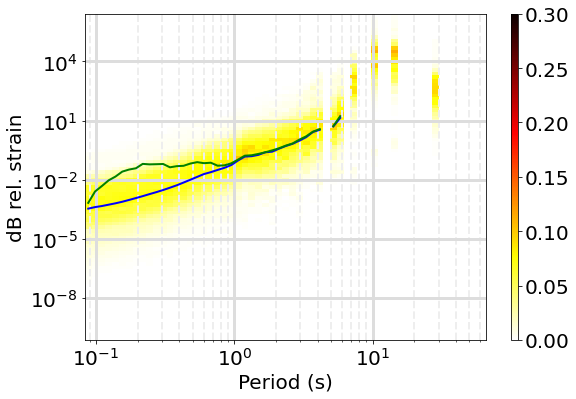

In [151]:
### plot PPSD for noise
sample = rawdata[1,6000:7500,:750]
H,xm,ym = ppsd(sample,sample_rate,0.015,12)
xm,mn,vr = psd_stats(H,xm,ym)

plt.figure(figsize=(9,6))
plt.pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.3, zorder=1)
plt.plot(1/xm,mn,'b',linewidth=2, zorder=2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.colorbar(aspect=50)
plt.grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
plt.grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
plt.xlabel('Period (s)')
plt.ylabel('dB rel. strain')

### plot PPSD for earthquake
sample = rawdata[1,6000:7500,750:]
H,xm,ym = ppsd(sample,sample_rate,0.015,12)
xm,mn,vr = psd_stats(H,xm,ym)

plt.plot(1/xm,mn,'green',linewidth=2, zorder=2)

0it [00:00, ?it/s]/tmp/ipykernel_3520937/1964896783.py:25: RuntimeWarning: invalid value encountered in divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
7it [00:00, 33.00it/s]


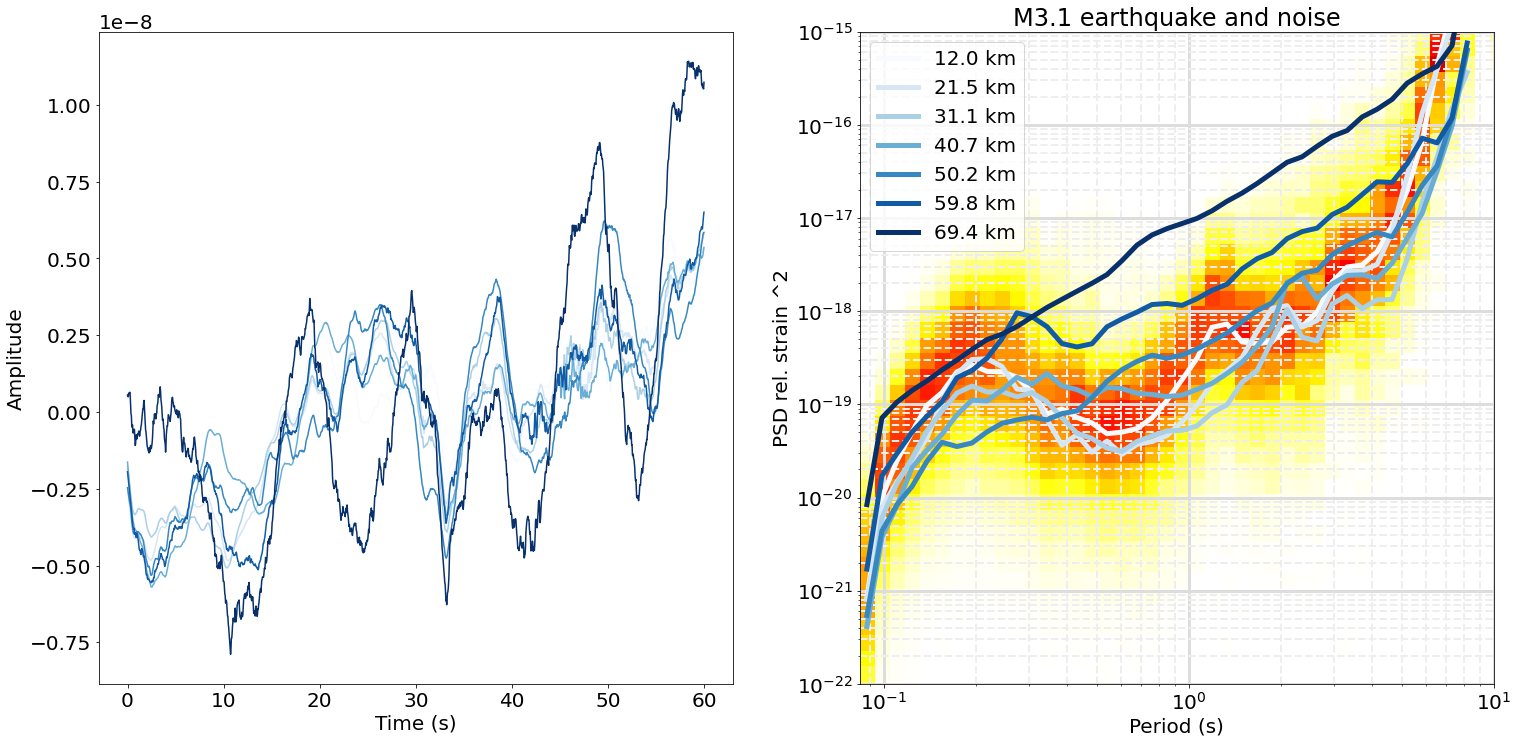

In [184]:
fig,ax = plt.subplots(1,2,figsize=(25,12))

colors = matplotlib.colormaps['Blues'](np.linspace(0, 1, 7))

# for i, chan in tqdm(enumerate(np.arange(500,2*ch_max+1,1000))):
for i, chan in tqdm(enumerate([9000, 10000, 11000, 12000, 13000, 14000, 15000])):
    
    ### Correct raw data to strain
    trs = rawdata[1,chan-500:chan,:].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
    
    H,xm,ym = ppsd(trs,sample_rate,0.015,12)
    xm,mn,vr = psd_stats(H,xm,ym)

    ax[0].plot(np.arange(1500) / sample_rate, np.mean(trs, axis=0), color=colors[i])
    ax[1].plot(1/xm, mn,linewidth=5, label='%.1f km' % ((chan-7500-250)*dchan*1e-3), zorder=2, color=colors[int(abs(i))])
    if i == 0:
        img=ax[1].pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)
        
    ### noise window
#     trs = rawdata[1,chan-500:chan,:750].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
    
#     H,xm,ym = ppsd(trs,sample_rate,0.015,12)
#     xm,mn,vr = psd_stats(H,xm,ym)
#     plt.plot(1/xm,mn,'k',linewidth=5, zorder=2, linestyle='dotted', color=colors[i])

        

ax[1].set_xscale('log')
ax[1].set_yscale('log')   
ax[1].set_xlim(1/12, 10)
ax[1].set_ylim(1e-22,1e-15)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Period (s)')
ax[1].set_ylabel('PSD rel. strain ^2')
ax[1].set_title('M3.1 earthquake and noise')
ax[1].grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax[1].grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
# plt.colorbar(img, ax=ax[1], aspect=50)


### plot PPSD for noise
# sample = rawdata[1,8500:9000,:750].astype(float) * (1550 * 1e-9) / (0.78 * 4 * np.pi * 1.4682 * 23.9)
# H,xm,ym = ppsd(sample,sample_rate,0.015,12)
# xm,mn,vr = psd_stats(H,xm,ym)

# plt.plot(1/xm,mn,'k',linewidth=10, zorder=2, linestyle='dotted', label='noise window', color=colors[i])
# # plt.colorbar(img, ax=ax[1]).set_label('probability')
plt.legend()
# plt.tight_layout()

In [7]:
### Bandpass filter removes long-period noises
### a common practise for earthquake detection

b, a = butter(4, (0.5, 12), fs=sample_rate, btype='bandpass')
filt = filtfilt(b, a, rawdata[0:2], axis=2)
rawdata_filt = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

0it [00:00, ?it/s]/tmp/ipykernel_3520937/3952121056.py:25: RuntimeWarning: invalid value encountered in divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
8it [00:00, 11.64it/s]


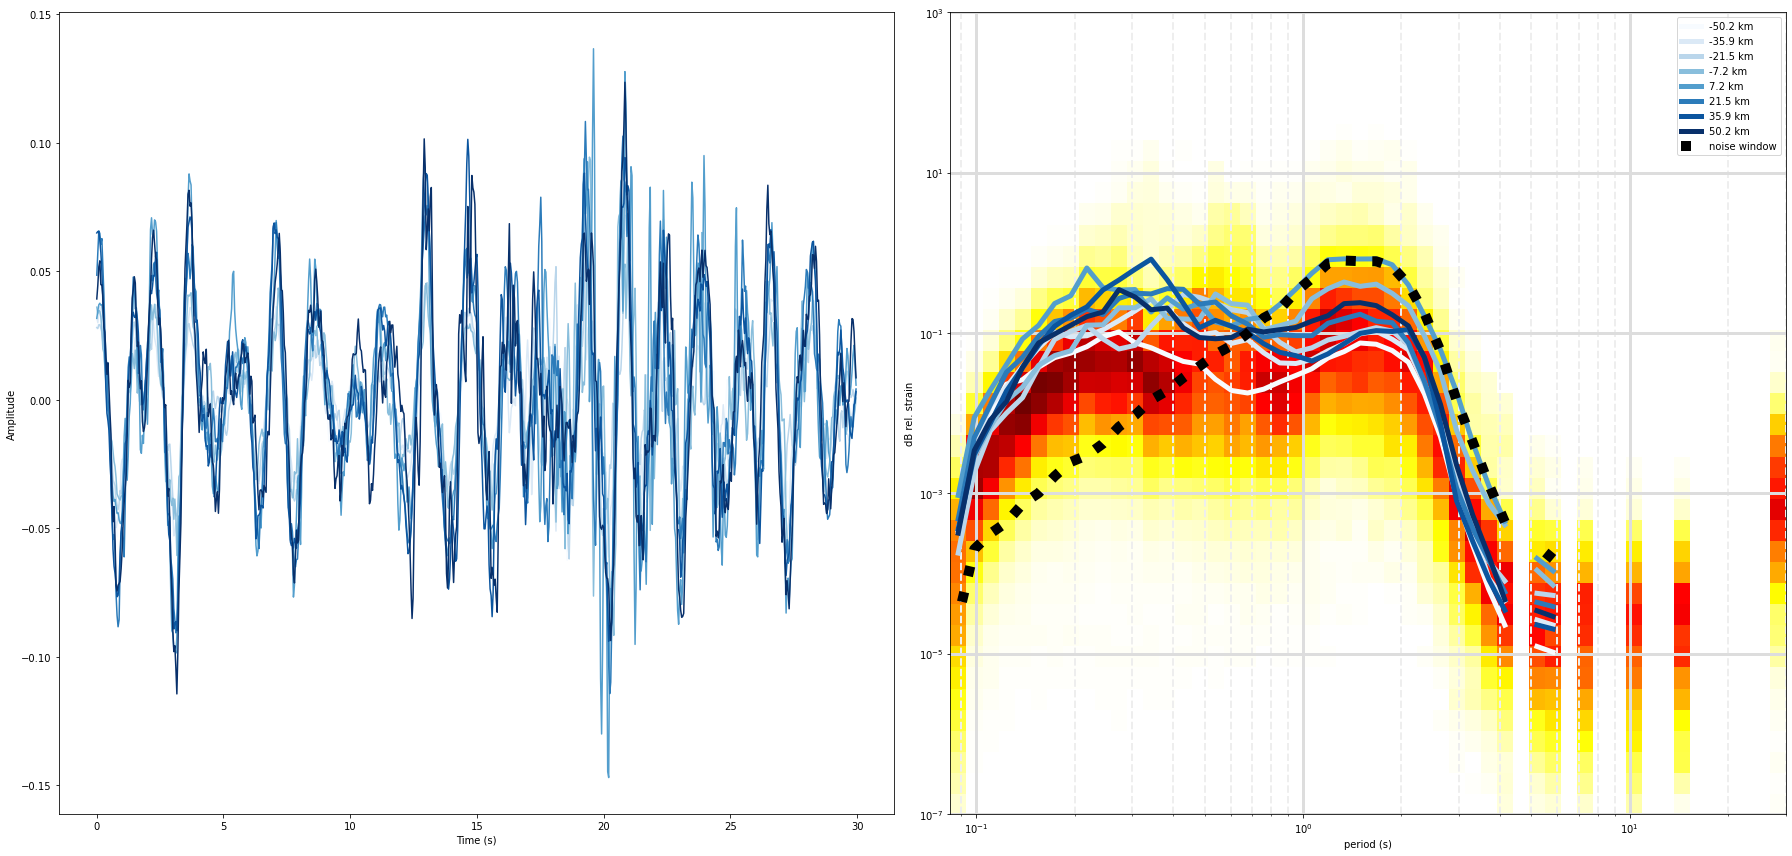

In [11]:
fig,ax = plt.subplots(1,2,figsize=(25,12))

colors = matplotlib.colormaps['Blues'](np.linspace(0, 1, 8))

for i, chan in tqdm(enumerate(np.arange(0,2*ch_max-1,1500))):
    
    ### Correct raw data to strain
    trs = rawdata_filt[1,chan:chan+1500,750:]
    
    H,xm,ym = ppsd(trs,sample_rate,0.015,12)
    xm,mn,vr = psd_stats(H,xm,ym)

    
    ax[0].plot(np.arange(750) / sample_rate, np.mean(trs, axis=0), color=colors[i])
    ax[1].plot(1/xm, mn,linewidth=5, label='%.1f km' % ((chan+750-6000)*dchan*1e-3), zorder=2, color=colors[i])
    if chan <= 5000:
        img=ax[1].pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)
        

ax[1].set_xscale('log')
ax[1].set_yscale('log')   
ax[1].set_xlim(1/12, 30)
ax[1].set_ylim(1e-7,1e3)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period (s)')
ax[1].set_ylabel('dB rel. strain')
ax[1].grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax[1].grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
# plt.colorbar(img, ax=ax[1], aspect=50)


### plot PPSD for earthquake
sample = rawdata_filt[1,6000:7500,:750]
H,xm,ym = ppsd(sample,sample_rate,0.015,12)
xm,mn,vr = psd_stats(H,xm,ym)

plt.plot(1/xm,mn,'k',linewidth=10, zorder=2, linestyle='dotted', label='noise window')

plt.legend()
plt.tight_layout()

In [95]:
with h5py.File('/fd1/QibinShi_data/akdas/qibin_data/Dec2023/kkfls_2023-12-02_08.30.57_UTC.h5', 'r') as f:
    attrs_raw0 = dict(f['Acquisition']['Raw[0]'].attrs)
    
    pulse_rate = f['Acquisition'].attrs['PulseRate']
    gauge_len = f['Acquisition'].attrs['GaugeLength']
    dchannel = f['Acquisition'].attrs['SpatialSamplingInterval']
    attrs = dict(f['Acquisition'].attrs)
    print(f['Acquisition'].keys())
    



<KeysViewHDF5 ['Raw[0]']>


In [102]:
sample_rate

1000.0